# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 807.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 52.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 58.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0


In [ ]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [15]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [16]:
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

In [17]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr  1 14:07:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [18]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [81]:
# разные режимы датасета 
data_modes = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
rescale_size = 224
# работаем на видеокарте
device = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [20]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in data_modes:
            print(f"{self.mode} is not correct; correct modes: {data_modes}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((rescale_size, rescale_size))
        return np.array(image)

In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [22]:
train_dir = Path('/kaggle/input/simpsons/train/simpsons_dataset')
test_dir = Path('/kaggle/input/simpsons/testset/testset')

train_val_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [23]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [24]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

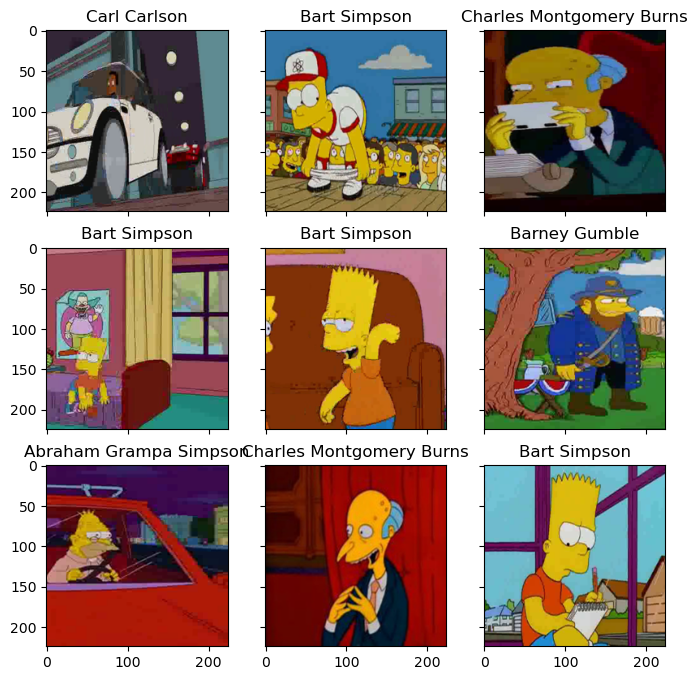

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [27]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [91]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [92]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [93]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [94]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [95]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(device)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [96]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [97]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.631432207893191


epoch:  50%|█████     | 1/2 [02:53<02:53, 173.39s/it]


Epoch 001 train_loss: 2.6314     val_loss 1.9128 train_acc 0.2630 val_acc 0.4826
loss 1.5008797383595442


epoch: 100%|██████████| 2/2 [05:28<00:00, 164.26s/it]


Epoch 002 train_loss: 1.5009     val_loss 1.2894 train_acc 0.5869 val_acc 0.6588


Построим кривые обучения

In [98]:
loss, acc, val_loss, val_acc = zip(*history)

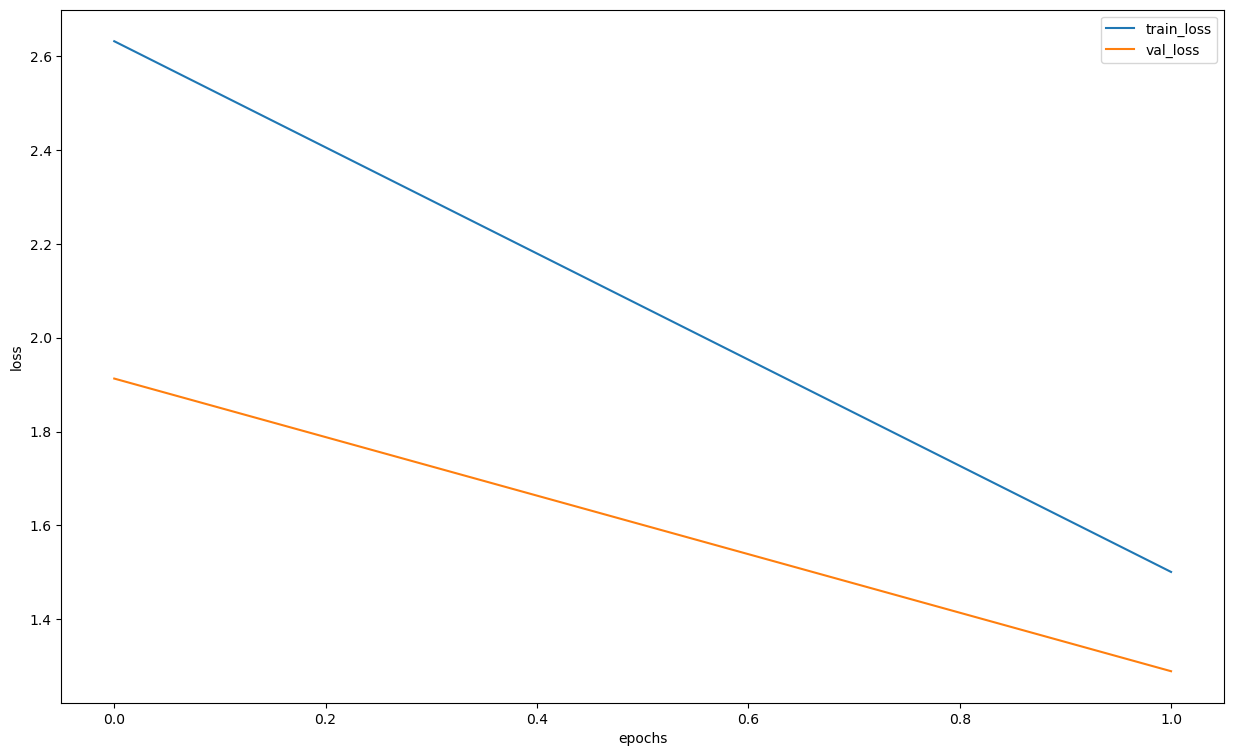

In [99]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [100]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [101]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [102]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [103]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [106]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [118]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.75

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

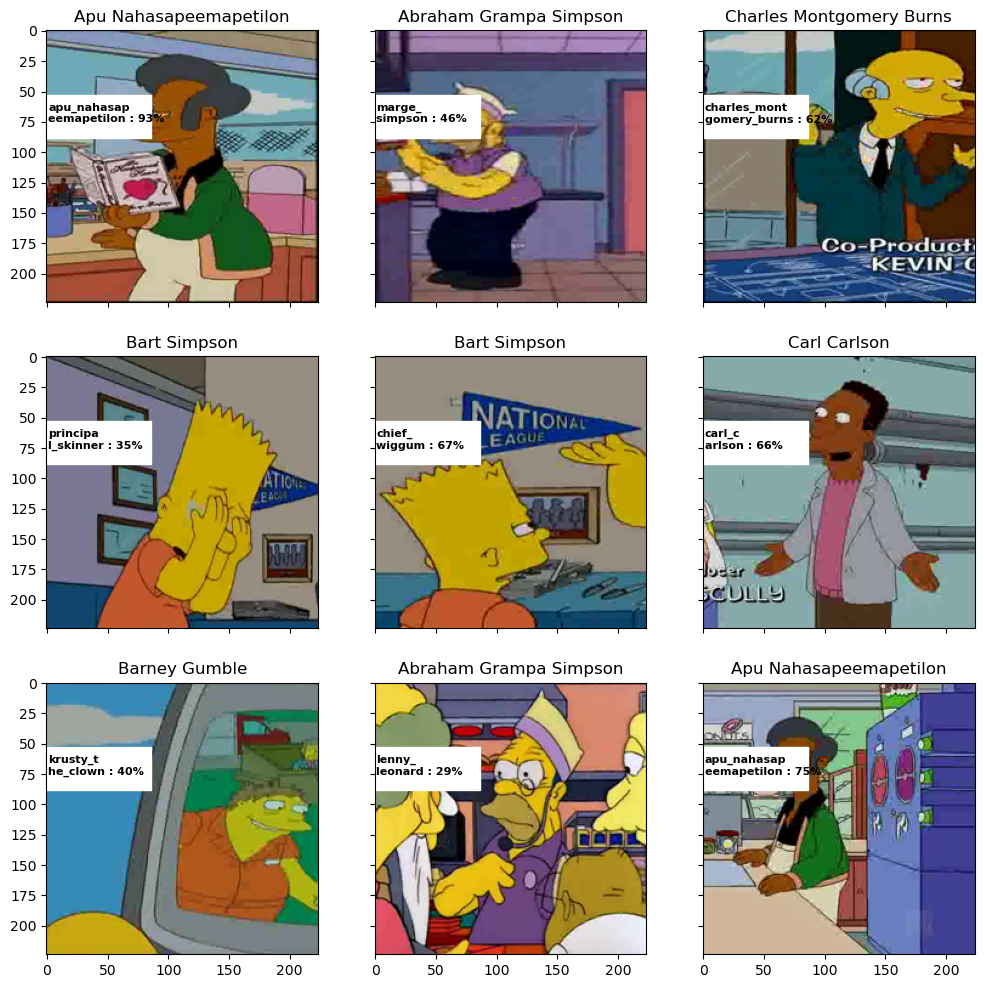

In [119]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [122]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [128]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit = my_submit.sort_values(by=['Id'])
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [130]:
my_submit.to_csv('/kaggle/working/label.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Мое решение

In [507]:
# Импортируемые библиотеки

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import cv2
import albumentations as A
from torchvision import models
from torchvision import transforms
import torchvision

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
import os
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [397]:
class SimpsonsDatasetMy(Dataset):
    def __init__(
        self, mode,
        split_param=0.9,
        mean_param=[0.485, 0.456, 0.406], 
        std_param=[0.229, 0.224, 0.225],
        resize_l=232,
        crop_l=224
    ):
        super().__init__()
        # Аналог LabelEncoder из baseline
        self.class2idx = dict()
        self.idx2class = dict()
        # Режим датасета
        self.mode = mode
        # Параметры трансформации для картинки
        self.resize_l = resize_l
        self.crop_l = crop_l
        self.data = list()
        self.mean = mean_param
        self.std = std_param
        # Количество классов
        self.classes_amount = 0
        
        if self.mode not in data_modes:
            print(f"{self.mode} is not correct; correct modes: {data_modes}")
            raise NameError
        
        # works only on kaggle with own data
        root = '/kaggle/input/simpsons'
        if self.mode in ['train', 'val']:
            root = os.path.join(root, 'train')
            root = os.path.join(root, 'simpsons_dataset')
            classes = sorted(os.listdir(root))
        elif self.mode == 'test':
            root = os.path.join(root, 'testset')
            root = os.path.join(root, 'testset')
            objects = os.listdir(root)
        
        # Сохраняем в список метку и путь до файла
        if self.mode in ['val', 'train']:
            for idx, class_name in enumerate(classes):
                self.classes_amount += 1
                self.class2idx[class_name] = idx
                self.idx2class[idx] = class_name
                class_path = os.path.join(root, class_name)
                class_files = os.listdir(class_path)
                class_amount = len(class_files)
                if self.mode == 'train':
                    class_files = class_files[:int(class_amount * split_param)]
                elif self.mode == 'val':
                    class_files = class_files[int(class_amount * split_param):]
                for file in class_files:
                    label = idx
                    file_path = os.path.join(class_path, file)
                    self.data.append((label, file_path))
        else:
            for obj in objects:
                file_path = os.path.join(root, obj)
                self.data.append(file_path)
                      
    def __len__(self):
        # возвращаем длину датасета
        return len(self.data)
  
    def __getitem__(self, index):
        # Трансформация
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
            transforms.CenterCrop(self.crop_l)
        ])
        
        if self.mode in ['val', 'train']:
            label, file_path = self.data[index]
        else:
            file_path = self.data[index]
        
        # Получаем картинку и преобразуем ее
        image = cv2.imread(file_path)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = np.stack((image, image, image), axis=2)
        
        image = cv2.resize(image, (self.resize_l, self.resize_l), interpolation=cv2.INTER_LINEAR)
        image = np.array(image / 255, dtype='float32')
        image = transform(image)
        
        if self.mode == 'test':
            return file_path, image
        else:
            return label, image

In [317]:
class ClassificationModelResnet(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # ResNet101
        self.inner_model = models.resnet101(
            weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V2
        )
        last_layer = nn.Linear(
            in_features = self.inner_model.fc.in_features,
            out_features = n_classes,
            bias = True
        )
        # Заменяем последний слой для нашей классификации
        self.inner_model.fc = nn.Sequential(
            nn.Flatten(),
            last_layer
        )
    
    def configure_optimizer(self):
        for child in list(self.inner_model.children()):
            for param in child.parameters():
                param.requires_grad = True
        
        # морозим часть слоев
        for child in list(self.inner_model.children())[:-3]:
            for param in child.parameters():
                param.requires_grad = False
        
        # Adam
        optimizer = torch.optim.Adam(
            params = [
                {'params': self.inner_model.layer4.parameters(), 'lr':1e-4},
                {'params': self.inner_model.fc.parameters(), 'lr':5e-4},
            ]
        )
        # scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=0.1
        )
        
        return optimizer, scheduler
  
    def forward(self, x):
        # forward
        return self.inner_model(x)

In [318]:
# Наши датасеты
train_data = SimpsonsDatasetMy(
    mode='train', resize_l=232, crop_l=224,
    mean_param=[0.485, 0.456, 0.406],
    std_param=[0.229, 0.224, 0.225]
)
val_data = SimpsonsDatasetMy(
    mode='val', resize_l=232, crop_l=224,
    mean_param=[0.485, 0.456, 0.406],
    std_param=[0.229, 0.224, 0.225]
)
test_data = SimpsonsDatasetMy(
    mode='test', resize_l=232, crop_l=224,
    mean_param=[0.485, 0.456, 0.406],
    std_param=[0.229, 0.224, 0.225]
)

# Наша модель
n_classes = train_data.classes_amount
model = ClassificationModelResnet(n_classes)
if torch.cuda.is_available():
    model = model.cuda()

In [319]:
# немного переделанные функции для обучения

def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for labels, inputs in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for labels, inputs in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_data, val_data, model, epochs, batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val_acc = None

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt, sch = model.configure_optimizer()
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if best_val_acc is None:
                best_weights = model.state_dict()
                best_val_acc = val_acc
            elif val_acc >= best_val_acc:
                best_weights = model.state_dict()
                best_val_acc = val_acc
            sch.step()
            
    return history

In [320]:
history = train(train_data, val_data, model, 9, 64)

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

loss 0.9734008303104121


epoch:  11%|█         | 1/9 [02:37<21:02, 157.87s/it]


Epoch 001 train_loss: 0.9734     val_loss 0.2999 train_acc 0.7634 val_acc 0.9224
loss 0.14599102019756938


epoch:  22%|██▏       | 2/9 [05:16<18:27, 158.19s/it]


Epoch 002 train_loss: 0.1460     val_loss 0.2128 train_acc 0.9644 val_acc 0.9475
loss 0.03755896948950957


epoch:  33%|███▎      | 3/9 [07:55<15:51, 158.64s/it]


Epoch 003 train_loss: 0.0376     val_loss 0.2069 train_acc 0.9913 val_acc 0.9550
loss 0.01203832369927202


epoch:  44%|████▍     | 4/9 [10:35<13:15, 159.09s/it]


Epoch 004 train_loss: 0.0120     val_loss 0.1861 train_acc 0.9985 val_acc 0.9560
loss 0.009352641633447501


epoch:  56%|█████▌    | 5/9 [13:13<10:34, 158.69s/it]


Epoch 005 train_loss: 0.0094     val_loss 0.1822 train_acc 0.9989 val_acc 0.9588
loss 0.008127262631745952


epoch:  67%|██████▋   | 6/9 [15:50<07:54, 158.24s/it]


Epoch 006 train_loss: 0.0081     val_loss 0.1761 train_acc 0.9991 val_acc 0.9593
loss 0.0064969000427347314


epoch:  78%|███████▊  | 7/9 [18:29<05:16, 158.33s/it]


Epoch 007 train_loss: 0.0065     val_loss 0.1865 train_acc 0.9992 val_acc 0.9593
loss 0.006891510394915511


epoch:  89%|████████▉ | 8/9 [21:08<02:38, 158.80s/it]


Epoch 008 train_loss: 0.0069     val_loss 0.1847 train_acc 0.9991 val_acc 0.9565
loss 0.006292551906935784


epoch: 100%|██████████| 9/9 [23:51<00:00, 159.11s/it]


Epoch 009 train_loss: 0.0063     val_loss 0.1820 train_acc 0.9994 val_acc 0.9560


In [457]:
epoch_history = dict()
epoch_history['train_loss'] = list()
epoch_history['train_acc'] = list()
epoch_history['val_loss'] = list()
epoch_history['val_acc'] = list()
epoch_history['epoch'] = list()
for idx, epoch in enumerate(history):
    train_loss, train_acc, val_loss, val_acc = epoch
    val_acc = float(val_acc.cpu().detach().numpy())
    epoch_history['epoch'].append(idx + 1)
    epoch_history['val_acc'].append(val_acc)
    epoch_history['val_loss'].append(val_loss)
    epoch_history['train_acc'].append(train_acc)
    epoch_history['train_loss'].append(train_loss)

epoch_history = pd.DataFrame(epoch_history)

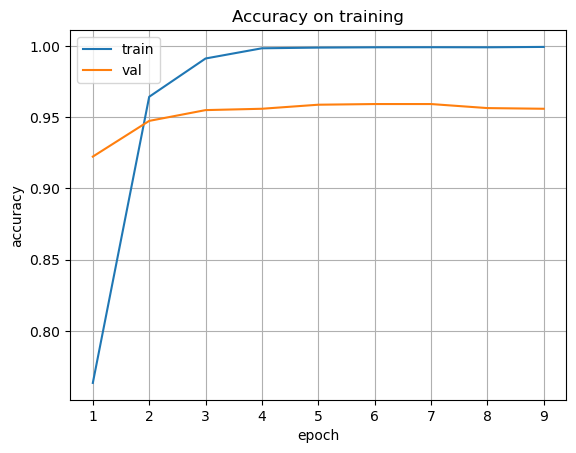

In [503]:
plt.plot(epoch_history['epoch'], epoch_history['train_acc'], label='train')
plt.plot(epoch_history['epoch'], epoch_history['val_acc'], label='val')

plt.title('Accuracy on training')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.grid(True)
plt.legend()
plt.show()

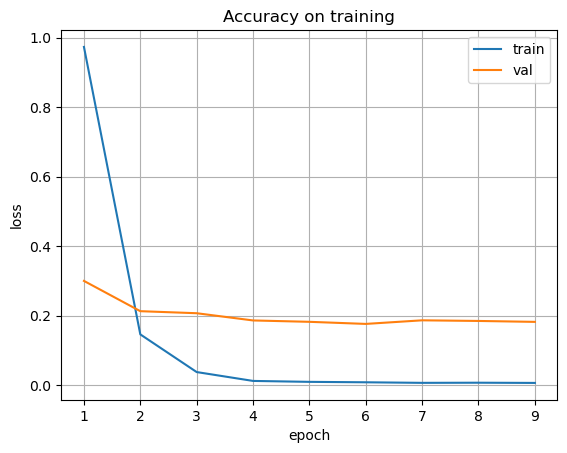

In [504]:
plt.plot(epoch_history['epoch'], epoch_history['train_loss'], label='train')
plt.plot(epoch_history['epoch'], epoch_history['val_loss'], label='val')

plt.title('Accuracy on training')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.grid(True)
plt.legend()
plt.show()

In [398]:
# получаем предсказания для тестовой части

def predict(test_data, model, idx2cls):
    model.eval()
    result = dict()
    result['Id'] = list()
    result['Expected'] = list()
    for file_path, image in test_data:
        image = image.to(device).unsqueeze(0)
        preds = model(image).cpu().detach()
        preds = torch.nn.functional.softmax(preds, dim=1)
        label = torch.argmax(preds, dim=1).tolist()[0]
        result['Id'].append(file_path.split('/')[-1])
        result['Expected'].append(idx2cls[label])
    
    return result

In [402]:
idx2cls = train_data.idx2class
predictions = predict(test_data, model, idx2cls)

In [404]:
predictions = pd.DataFrame(predictions)
predictions.to_csv('/kaggle/working/label.csv', index=False)

### Результаты с kaggle для предсказаний

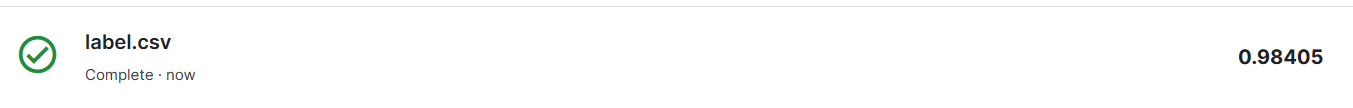